<a href="https://colab.research.google.com/github/saokotie/Applied-Machine-Learning/blob/main/Worksheet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow: 2.19.0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  53.8M      0  0:00:14  0:00:14 --:--:-- 62.0M
Top-level entries: ['.config', 'PetImages', 'CDLA-Permissive-2.0.pdf', 'readme[1].txt', 'kagglecatsanddogs_5340.zip', 'sample_data']
PetImages subfolders: ['Dog', 'Cat']
Deleted 1590 images
Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


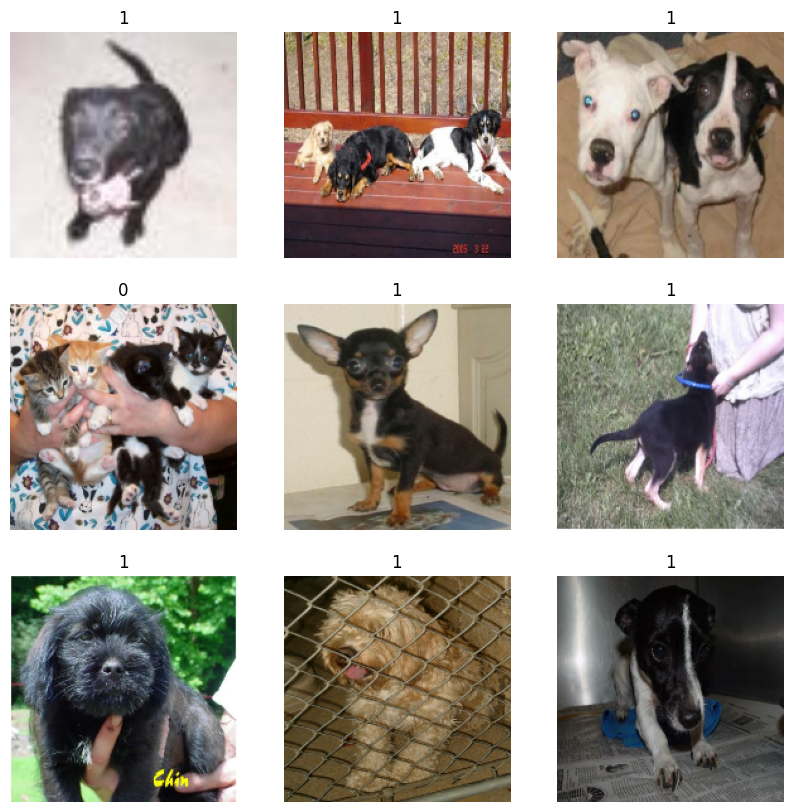

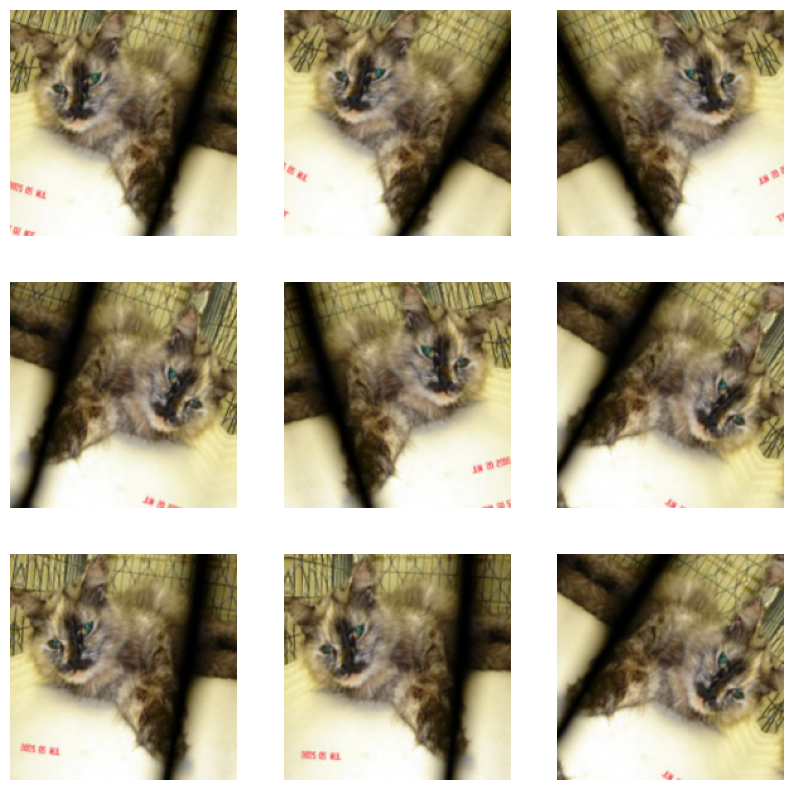

Saved model diagram to model.png
Epoch 1/50
341/586 ━━━━━━━━━━━━━━━━━━━━ 42:30 10s/step - accuracy: 0.5988 - loss: 0.7135

In [ ]:
# =========================
# 1. Setup:
# =========================
import os, zipfile, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
import matplotlib.pyplot as plt
SEED = 1337
tf.keras.utils.set_random_seed(SEED)

# =========================
# 2. Load the data:
# (Raw data download from the Cats vs Dogs dataset)
# =========================
zip_path = "kagglecatsanddogs_5340.zip"
if not os.path.exists(zip_path):
    # Colab-style download; in Jupyter, you can also use requests/urllib.
    !curl -L -o kagglecatsanddogs_5340.zip \
      https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

# =========================
# 3. Unzip the data:
# =========================
if not os.path.exists("PetImages"):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(".")
print("Top-level entries:", os.listdir(".")[:10])
if os.path.exists("PetImages"):
    print("PetImages subfolders:", os.listdir("PetImages"))

# =========================
# 4. Filter out corrupted images:
# (safer approach; still checks for 'JFIF' in header per worksheet)
# =========================
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    if not os.path.isdir(folder_path):
        continue
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, "rb") as fobj:
                header = fobj.peek(10)
                is_jfif = b"JFIF" in header
            if not is_jfif:
                os.remove(fpath)
                num_skipped += 1
        except Exception:
            # Any unreadable or non-image file → remove
            try:
                os.remove(fpath)
                num_skipped += 1
            except Exception:
                pass
print("Deleted %d images" % num_skipped)

# =========================
# 5. Generate a Dataset:
# (use modern utils API to avoid deprecations)
# =========================
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

# =========================
# 6. Visualise the data:
# =========================
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

# =========================
# 7. Using image data augmentation:
# =========================
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ],
    name="augmentation",
)

# =========================
# 8. Augmented samples visualisation:
# (apply augmentation repeatedly to the first batch)
# =========================
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

# =========================
# 9. Standardising while preprocessing the data:
# (values to [0,1] via Rescaling inside the model; create augmented_train_ds to match worksheet)
# =========================
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# =========================
# 10. Configure the dataset for performance:
# (cache + prefetch; AUTOTUNE preferred)
# =========================
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

# =========================
# 11. Build a model:
# (mini Xception-style; starts with augmentation + Rescaling; includes Dropout)
# =========================
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block (inactive at inference)
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Prepare next residual

    # Exit block
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
# Optional: requires graphviz/pydot; guarded to avoid errors
try:
    keras.utils.plot_model(model, show_shapes=True, to_file="model.png")
    print("Saved model diagram to model.png")
except Exception as e:
    print("plot_model skipped:", e)

# =========================
# 12. Train the model:
# (epochs can be 50 as in the worksheet; reduce if running out of time/RAM)
# =========================
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

# =========================
# 13. Run inference on new data:
# (augmentation & dropout are inactive at inference time)
# =========================
sample_path = "PetImages/Cat/6779.jpg"
if not os.path.exists(sample_path):
    # fallback: find any remaining image
    for cls in ("Cat", "Dog"):
        folder = os.path.join("PetImages", cls)
        if os.path.isdir(folder):
            imgs = [os.path.join(folder, f) for f in os.listdir(folder)
                    if f.lower().endswith((".jpg", ".jpeg", ".png"))]
            if imgs:
                sample_path = imgs[0]
                break

print("Using sample:", sample_path)
img = keras.utils.load_img(sample_path, target_size=image_size)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

pred = model.predict(img_array, verbose=0)[0]
score = float(pred)
print("This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score))
